In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [8]:
path = 'data.csv'

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [10]:
data = pd.read_csv(path)
# сначала избавимся от всех тех колонок, которые не нужны в 2м дз по условию  
data.drop(["banner_id0", "banner_id1", "rate0", "rate1", "g0", "g1", "coeff_sum0", "coeff_sum1"], axis=1, inplace=True)
data.head()

,date_time,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,impressions,clicks
0,2021-09-27 00:01:30.000000,0,0,5664530014561852622,0,0,0,1,1
1,2021-09-26 22:54:49.000000,1,1,5186611064559013950,0,0,1,1,1
2,2021-09-26 23:57:20.000000,2,2,2215519569292448030,3,0,0,1,1
3,2021-09-27 00:04:30.000000,3,3,6262169206735077204,0,1,1,1,1
4,2021-09-27 00:06:21.000000,4,4,4778985830203613115,0,1,0,1,1


In [4]:
def analysis(data: pd.DataFrame):
    # проверим, есть ли null значения
    count_null = data.isnull().sum().sum()
    print('Количетво null значений =', count_null)
    # посмотрим на уникальные значения для каждой фичи и для изучения распределения построим гистограмму
    features = ['os_id', 'country_id', 'banner_id', 'zone_id', 'impressions', 'campaign_clicks']
    for feature in features:
        uniq_vals = data[feature].nunique()
        print(f"Количество уникальных значений для {feature}:  {uniq_vals}")
        plt.hist(data[feature], bins=min(50,uniq_vals))
        plt.show()
   # на какие-то характеристик даты посмотрим отдельно
    data['date_time'] = pd.to_datetime(data['date_time'])
    data_time = data.copy()
    data_time['date'] = data['date_time'].dt.date
    print(data_time['date'].value_counts())


Количетво null значений = 0
Количество уникальных значений для os_id:  11


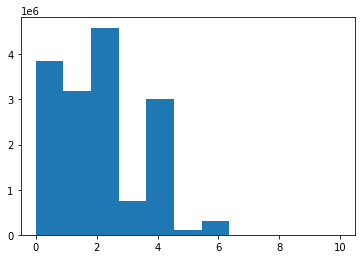

Количество уникальных значений для country_id:  17


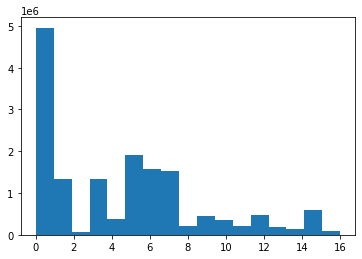

Количество уникальных значений для banner_id:  1633


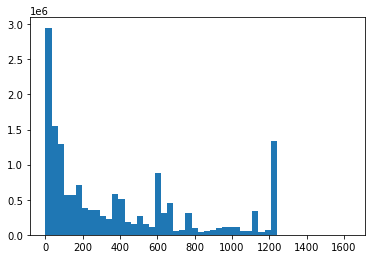

Количество уникальных значений для zone_id:  3444


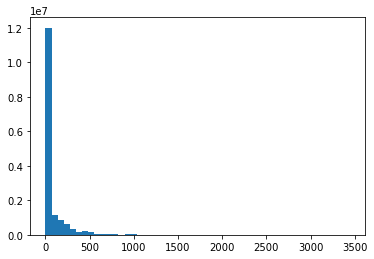

Количество уникальных значений для impressions:  1


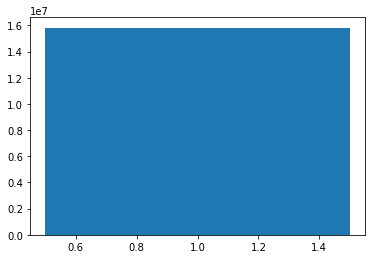

Количество уникальных значений для campaign_clicks:  822


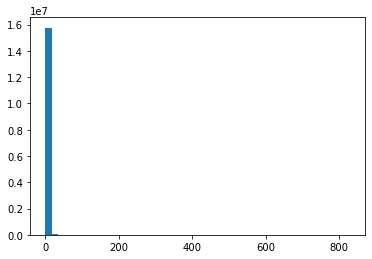

2021-09-26    3102610
2021-09-29    2420588
2021-09-27    2367303
2021-09-28    2307355
2021-10-02    2128978
2021-09-30    1851189
2021-10-01    1643448
2021-09-01          1
Name: date, dtype: int64


In [5]:
analysis(data)

Я оставила тут анализ данных из 1го ноутбука 

In [6]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [7]:
print(data.head())

            date_time  zone_id  banner_id            oaid_hash  \
0 2021-09-27 00:01:30        0          0  5664530014561852622   
1 2021-09-26 22:54:49        1          1  5186611064559013950   
2 2021-09-26 23:57:20        2          2  2215519569292448030   
3 2021-09-27 00:04:30        3          3  6262169206735077204   
4 2021-09-27 00:06:21        4          4  4778985830203613115   

   campaign_clicks  os_id  country_id  impressions  clicks  
0                0      0           0            1       1  
1                0      0           1            1       1  
2                3      0           0            1       1  
3                0      1           1            1       1  
4                0      1           0            1       1  


In [11]:
def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:
    # чистим данные в соответствии с выводами из 1й домашки
    data['date_time'] = pd.to_datetime(data['date_time'])
    data = data.drop(['impressions'], axis=1)
    data = data[data['date_time'] > '2021-09-02']

    # делаем разбиение на трейн, валидацию и тест: берем в тест последний день, а в валидацию - предпоследний
    data = data.set_index('date_time')
    train = data.loc[:'2021-09-30'].copy()
    val = data.loc['2021-10-01'].copy()
    test = data.loc['2021-10-02'].copy()
    return train, test, val

In [12]:
train, test, val = feature_engineering(data)

In [10]:
print(val)

                     zone_id  banner_id            oaid_hash  campaign_clicks  \
date_time                                                                       
2021-10-01 00:00:31       28          7   492990345605388039                0   
2021-10-01 00:01:00       27         49  3285764467821396365                0   
2021-10-01 00:04:29       27          0  8175386138407715203                0   
2021-10-01 00:00:54       40         56  1250565564060433108                0   
2021-10-01 00:03:00        1          0  1180914103150185697                0   
...                      ...        ...                  ...              ...   
2021-10-01 15:30:01       14       1236  2478507265809838415                0   
2021-10-01 00:05:15       18         49  7409908008354123933                0   
2021-10-01 08:42:01      521        673  1904835429820185568                0   
2021-10-01 12:24:29        2         50  7827364127462933216                0   
2021-10-01 20:46:50       14

Т.к можно пользоваться сторонними библиотеками, то я взяла приведение к формату отсюда
https://github.com/wngaw/blog/blob/master/xlearn_example/src/utils.py

In [14]:
from tqdm import tqdm
import math

def _convert_to_ffm(path, df, type, target, numerics, categories, features, encoder):
    # Flagging categorical and numerical fields
    print('convert_to_ffm - START')
    for x in numerics:
        if(x not in encoder['catdict']):
            print(f'UPDATING CATDICT: numeric field - {x}')
            encoder['catdict'][x] = 0
    for x in categories:
        if(x not in encoder['catdict']):
            print(f'UPDATING CATDICT: categorical field - {x}')
            encoder['catdict'][x] = 1

    nrows = df.shape[0]
    with open(path + str(type) + "_ffm.txt", "w") as text_file:

        # Looping over rows to convert each row to libffm format
        for n, r in tqdm(enumerate(range(nrows)), "Formatting", nrows):
            datastring = ""
            datarow = df.iloc[r].to_dict()
            datastring += str(int(datarow[target]))  # Set Target Variable here

            # For numerical fields, we are creating a dummy field here
            for i, x in enumerate(encoder['catdict'].keys()):
                if(encoder['catdict'][x] == 0):
                    # Not adding numerical values that are nan
                    if math.isnan(datarow[x]) is not True:
                        datastring = datastring + " "+str(i)+":" + str(i)+":" + str(datarow[x])
                else:

                    # For a new field appearing in a training example
                    if(x not in encoder['catcodes']):
                        #print(f'UPDATING CATCODES: categorical field - {x}')
                        encoder['catcodes'][x] = {}
                        encoder['currentcode'] += 1
                        # print(f'UPDATING CATCODES: categorical value for field {x} - {datarow[x]}')
                        encoder['catcodes'][x][datarow[x]] = encoder['currentcode']  # encoding the feature

                    # For already encoded fields
                    elif(datarow[x] not in encoder['catcodes'][x]):
                        encoder['currentcode'] += 1
                        #print(f'UPDATING CATCODES: categorical value for field {x} - {datarow[x]}')
                        encoder['catcodes'][x][datarow[x]] = encoder['currentcode']  # encoding the feature

                    code = encoder['catcodes'][x][datarow[x]]
                    datastring = datastring + " "+str(i)+":" + str(int(code))+":1"

            datastring += '\n'
            text_file.write(datastring)
    return encoder


In [12]:
TARGET = ['clicks']
NUMERICAL_FEATURES = ['campaign_clicks']
CATEGORICAL_FEATURES = ['zone_id','banner_id','oaid_hash','os_id','country_id']
ALL_FEATURES = ['zone_id','banner_id','oaid_hash','campaign_clicks','os_id','country_id']

In [17]:
encoder = {"currentcode": len(NUMERICAL_FEATURES),
           "catdict": {},
           "catcodes": {}}

In [18]:
encoder = _convert_to_ffm('', train, 'train', TARGET[0],
                          NUMERICAL_FEATURES,
                          CATEGORICAL_FEATURES,
                          ALL_FEATURES,
                          encoder)

convert_to_ffm - START
UPDATING CATDICT: numeric field - campaign_clicks
UPDATING CATDICT: categorical field - zone_id
UPDATING CATDICT: categorical field - banner_id
UPDATING CATDICT: categorical field - oaid_hash
UPDATING CATDICT: categorical field - os_id
UPDATING CATDICT: categorical field - country_id


Formatting: 100%|██████████| 12049045/12049045 [26:31<00:00, 7571.22it/s]


In [19]:
encoder = _convert_to_ffm('', val, 'val', TARGET[0],
                          NUMERICAL_FEATURES,
                          CATEGORICAL_FEATURES,
                          ALL_FEATURES,
                          encoder)

convert_to_ffm - START


Formatting: 100%|██████████| 1643448/1643448 [03:38<00:00, 7512.65it/s]


In [20]:
encoder = _convert_to_ffm('', test, 'test', TARGET[0],
                          NUMERICAL_FEATURES,
                          CATEGORICAL_FEATURES,
                          ALL_FEATURES,
                          encoder)

convert_to_ffm - START


Formatting: 100%|██████████| 2128978/2128978 [04:45<00:00, 7466.32it/s]


In [ ]:
!pip install xlearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 6.2 MB/s eta 0:00:00m eta 0:00:010:01:01
  Preparing metadata (setup.py) ... done

In [1]:
import xlearn as xl

К сожалению, на колабе у меня не хватало оперативы, пришлось учить локально, поэтому вывод xlearnа шел в консоль. На каждую итерацию перебора параметра k приложен скрин из консоли. Также не удалось запустить именно грид серч по k, потому что сама модель весит много и у меня не хватило памяти. Поэтому валидация немножко ручная.

In [16]:
ffm_model = xl.create_ffm()
ffm_model.setTrain("train_ffm.txt")
ffm_model.setValidate("val_ffm.txt")
param = {'task':'binary', 'lr':0.1, 'lambda':0.000002, 'metric': 'auc', 'epoch':20, 'k': 2}

In [17]:
ffm_model.fit(param, "model_10.out")

In [2]:
import matplotlib.pyplot as plt

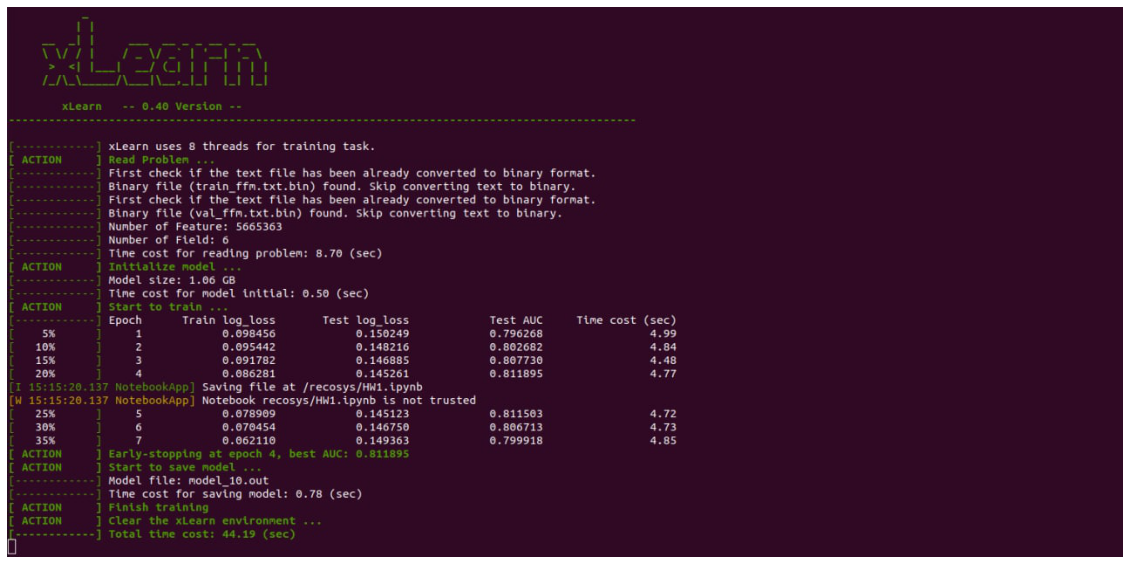

In [5]:
img = plt.imread('k_2.jpg')
plt.figure(figsize=(20,16))
plt.imshow(img)
plt.axis('off')
plt.show()

In [5]:
ffm_model = xl.create_ffm()
ffm_model.setTrain("train_ffm.txt")
ffm_model.setValidate("val_ffm.txt")
param = {'task':'binary', 'lr':0.1, 'lambda':0.000002, 'metric': 'auc', 'epoch':20, 'k': 4}

In [6]:
ffm_model.fit(param, "model_10.out")

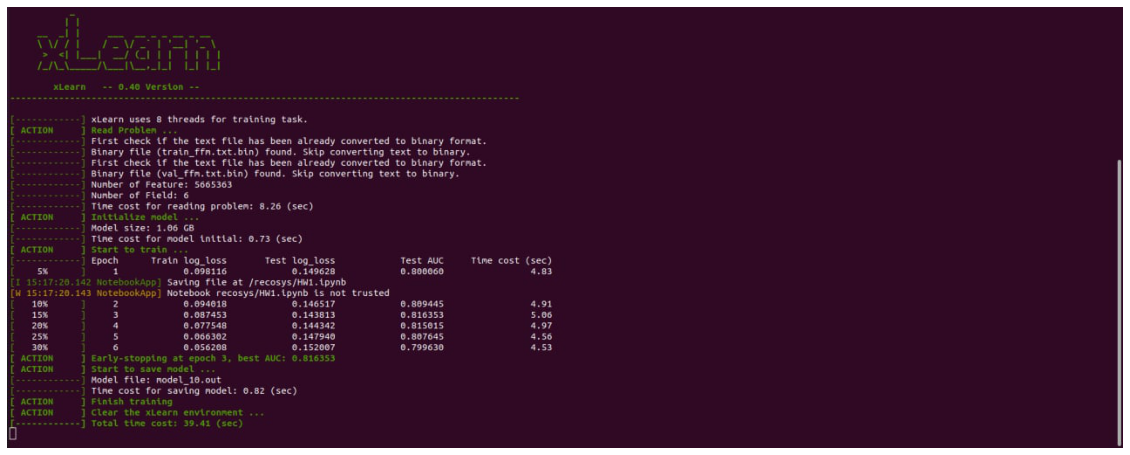

In [6]:
img = plt.imread('k_4.jpg')
plt.figure(figsize=(20,16))
plt.imshow(img)
plt.axis('off')
plt.show()

In [7]:
ffm_model = xl.create_ffm()
ffm_model.setTrain("train_ffm.txt")
ffm_model.setValidate("val_ffm.txt")
param = {'task':'binary', 'lr':0.1, 'lambda':0.000002, 'metric': 'auc', 'epoch':20, 'k': 6}

In [8]:
ffm_model.fit(param, "model_10.out")

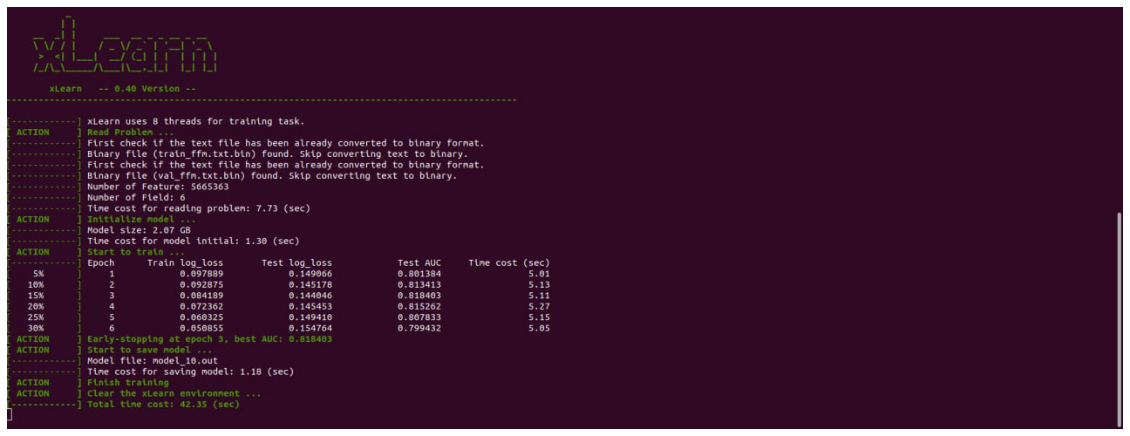

In [7]:
img = plt.imread('k_6.jpg')
plt.figure(figsize=(20,16))
plt.imshow(img)
plt.axis('off')
plt.show()

In [5]:
ffm_model = xl.create_ffm()
ffm_model.setTrain("train_ffm.txt")
ffm_model.setValidate("val_ffm.txt")
param = {'task':'binary', 'lr':0.1, 'lambda':0.000002, 'metric': 'auc', 'epoch':20, 'k': 8}

In [6]:
ffm_model.fit(param, "model_10.out")

In [7]:
ffm_model.setTest("test_ffm.txt")
ffm_model.setSigmoid()
ffm_model.predict("model_10.out", "predictions.txt")

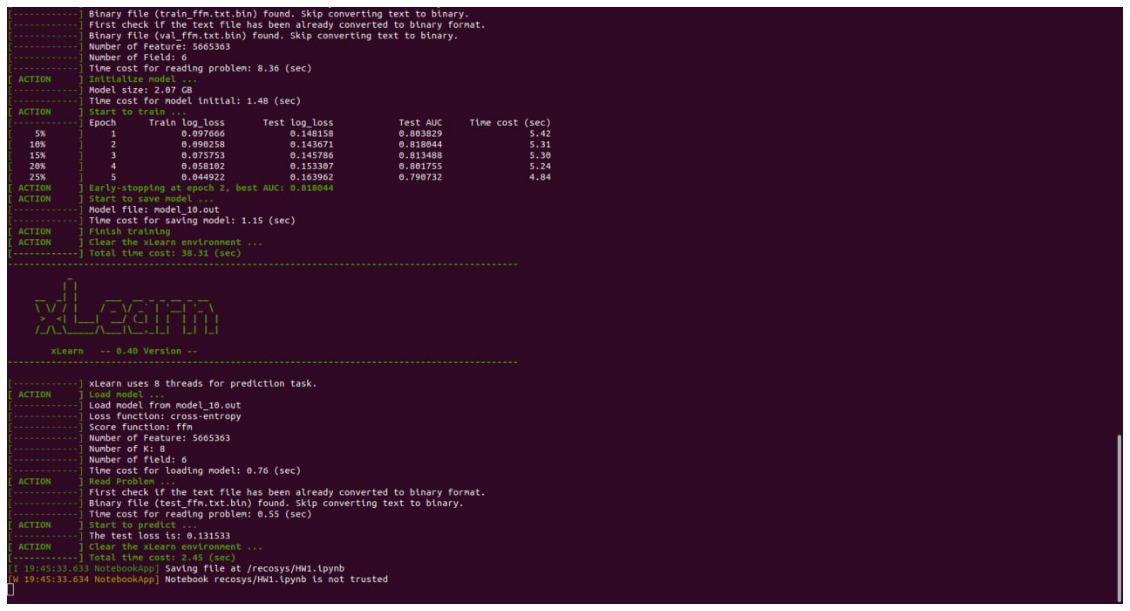

In [16]:
img = plt.imread('k_8.jpg')
plt.figure(figsize=(20,16))
plt.imshow(img)
plt.axis('off')
plt.show()

In [13]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss

In [14]:
y_pred = pd.read_csv("predictions.txt", header=None)
roc_auc_score(test['clicks'], y_pred)


0.7972813275829636

In [15]:
logloss = log_loss(test['clicks'], y_pred)
print(logloss)

0.13154992102511567


Ниже кусок кода из 1й домашки, связанный с результатами линейной модели, как видно ffm побил ее и по auc, и по log loss. Кажется, что основную роль сыграл очень маленький штраф 'lambda':0.000002

In [ ]:
# создаем модель, берем логистическую регрессию: оптимизатор liblinear - не SGD like + обсуждалась на лекции, поэтому взяла его
# состояние фиксируем для воспроизводимости 
def create_model(C=0.1):
    model = LogisticRegression(solver='liblinear', C=C, penalty='l2', random_state=42)
    return model

In [ ]:
from sklearn.model_selection import cross_validate

In [ ]:
from sklearn.feature_selection import SelectFromModel

In [ ]:
# слишком много фич, поэтому возьмем только те, чьи веса важны
model = create_model()
model_cut = SelectFromModel(model)
model_cut.fit(X_train, y_train)


SelectFromModel(estimator=LogisticRegression(C=0.1, random_state=42,
                                             solver='liblinear'))

In [ ]:
X_train = model_cut.transform(X_train)
X_test = model_cut.transform(X_test)

In [ ]:
# сделем кросс-валидацию: зададим +- стандартную сетку параметра регуляризации и переберем ее,
# перебирать виды регуляризации долго, я остановилась сразу на l2
def cv():
    C_grid = [0.001, 0.01, 0.1, 1.0, 10.0]

    for C in C_grid:
      model = create_model(C=C)
      res = cross_validate(model, X_train, y_train, scoring=['neg_log_loss', 'roc_auc'], cv=5)
      print("C= " , C)
      print('Log loss ', -np.mean(res['test_neg_log_loss']))
      print('Roc auc ', np.mean(res['test_roc_auc']))
    return res

In [ ]:
res = cv()

C=  0.001
Log loss  0.11088218866473756
Roc auc  0.7044281189350821
C=  0.01
Log loss  0.11016700368551494
Roc auc  0.7150845006866104
C=  0.1
Log loss  0.11018285413721492
Roc auc  0.7166397799755533
C=  1.0
Log loss  0.11022325856755526
Roc auc  0.7169563400222765
C=  10.0
Log loss  0.11024711099902777
Roc auc  0.7169926618347953


In [ ]:
best_C = 0.01

In [ ]:
from sklearn.metrics import log_loss, roc_auc_score

In [ ]:
# обучим модель с лучшим коэффициентом регуляризации
model = create_model(best_C)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
logloss = log_loss(y_test, model.predict_proba(X_test))
print('Auc roc = ', auc,'   logloss = ', logloss)

# сравним с бейзлайном: предикт среднего по выборке
y_pred_baseline = np.full(y_pred.shape, np.mean(y_train))
auc_baseline = roc_auc_score(y_test, y_pred_baseline)
logloss_baseline = log_loss(y_test, y_pred_baseline)
print('Auc roc = ', auc_baseline,'   logloss = ', logloss_baseline)

Auc roc =  0.7788281176914976    logloss =  0.13364395049140051
Auc roc =  0.5    logloss =  0.15486197934508547


In [ ]:
print(np.sum(y_pred))
print(np.sum(y_test))

188
75362


Ура, побили бейзлайн